Task 1

SPX

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:

# Daten einlesen
data = pd.read_parquet('data/spx_ivs_2023-02.parquet')
data['date'] = pd.to_datetime(data['loctimestamp'], unit='ms').dt.date

# Risikofreier Zinssatz je Tag einlesen
rf_df = pd.read_csv('data/riskfree_30d_2023-02.csv', parse_dates=['date'])
rf_df['date'] = rf_df['date'].dt.date
rf_dict = rf_df.set_index('date')['yld_pct_annual'].to_dict()

tau = 30 / 365  # 30 Tage in Jahren
results = []

for day in pd.date_range(start='2023-02-01', end='2023-02-28'):
    date = day.date()
    data_day = data[data['date'] == date]
    if data_day.empty:
        continue
    
    # Tagesabhängigen risikofreien Zinssatz holen (in Dezimal, z.B. 0.0468)
    r = rf_dict.get(date, 3) / 100  # Falls kein Wert, Default 3%
    
    S_t = data_day['underlyingprice'].iloc[0]
    options = data_day[data_day['implPrice'].notnull()]
    
    integrand_calls_var = []
    integrand_puts_var = []
    integrand_calls_skew = []
    integrand_puts_skew = []
    integrand_calls_kurt = []
    integrand_puts_kurt = []
    
    Kc = []
    Kp = []

    for _, row in options.iterrows():
        K = row['strike']
        price = row['implPrice']
        if price <= 0:
            continue

        if row['putcall'] == 'C' and K >= S_t:
            log_term = np.log(K / S_t)

            w_var = (2 * (1 - log_term)) / K**2
            w_skew = (6 * log_term - 3 * log_term**2) / K**2
            w_kurt = (12 * log_term**2 - 4 * log_term**3) / K**2

            integrand_calls_var.append(w_var * price)
            integrand_calls_skew.append(w_skew * price)
            integrand_calls_kurt.append(w_kurt * price)
            Kc.append(K)

        elif row['putcall'] == 'P' and K < S_t:
            log_term = np.log(S_t / K)

            w_var = (2 * (1 + log_term)) / K**2
            w_skew = -(6 * log_term + 3 * log_term**2) / K**2
            w_kurt = (12 * log_term**2 + 4 * log_term**3) / K**2

            integrand_puts_var.append(w_var * price)
            integrand_puts_skew.append(w_skew * price)
            integrand_puts_kurt.append(w_kurt * price)
            Kp.append(K)

    if len(Kc) < 2 or len(Kp) < 2:
        continue

    # Integration mit Trapezregel
    var_calls = np.trapz(integrand_calls_var, Kc)
    var_puts = np.trapz(integrand_puts_var, Kp)
    V = (var_calls + var_puts)
    sigma = np.sqrt(V)

    skew_calls = np.trapz(integrand_calls_skew, Kc)
    skew_puts = np.trapz(integrand_puts_skew, Kp)
    W = (skew_calls + skew_puts)  

    kurt_calls = np.trapz(integrand_calls_kurt, Kc)
    kurt_puts = np.trapz(integrand_puts_kurt, Kp)
    X = (kurt_calls + kurt_puts)  
    
    # Erwartungswert mu(t, tau)
    mu = (np.exp(r * tau) - 1
          - (np.exp(r * tau) / 2) * V
          - (np.exp(r * tau) / 6) * W
          - (np.exp(r * tau) / 24) * X)

    # Erwartete Skewness SKEW(t, tau)
    numerator_skew = (np.exp(r * tau) * W
                      - 3 * mu * np.exp(r * tau) * V
                      + 2 * mu**3)
    denominator_skew = (np.exp(r * tau) * V - mu**2)**(3/2)
    expected_skew = numerator_skew / denominator_skew if denominator_skew != 0 else np.nan

    # Erwartete Kurtosis (Excess Kurtosis), analog berechnet
    numerator_kurt = (np.exp(r * tau) * X
                      - 4 * mu * np.exp(r * tau) * W
                      + 6 * mu**2 * np.exp(r * tau) * V
                      - 3 * mu**4)
    denominator_kurt = (np.exp(r * tau) * V - mu**2)**2
    expected_kurt = numerator_kurt / denominator_kurt if denominator_kurt != 0 else np.nan

    results.append({
        'date': date,
        'underlying_price': S_t,
        'V': V,
        'W': W,
        'X': X,
        'mu': mu,
        'skewness': expected_skew,
        'kurtosis': expected_kurt
    })

results_df = pd.DataFrame(results)


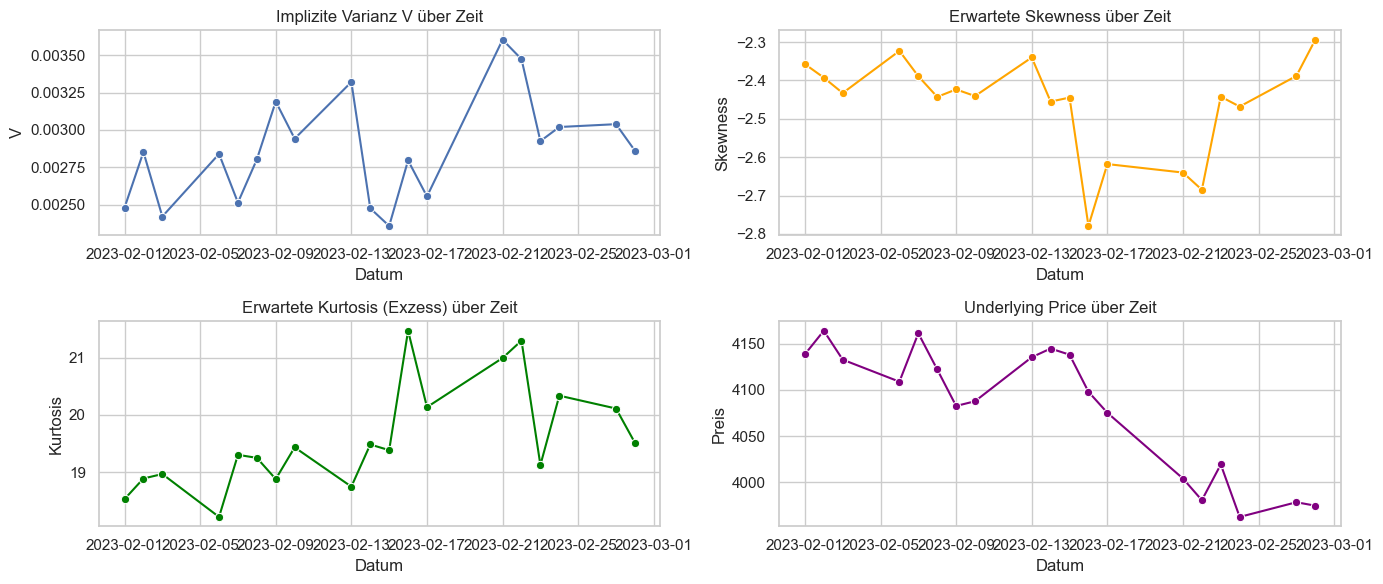

In [15]:
# Ergebnisse laden (wenn du aus vorherigem Code kommst, einfach weitermachen)
# results_df = ...

# Optional: Stil setzen
sns.set(style="whitegrid")

# Konvertiere Datum zur besseren Achsenbeschriftung
results_df['date'] = pd.to_datetime(results_df['date'])

# Setze die Größe der Figuren
plt.figure(figsize=(14, 6))

# --- 1. Volatilitätsmaß (V) über Zeit ---
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='V', data=results_df, marker='o')
plt.title('Implizite Varianz V über Zeit')
plt.xlabel('Datum')
plt.ylabel('V')

# --- 2. Erwartete Skewness ---
plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='skewness', data=results_df, marker='o', color='orange')
plt.title('Erwartete Skewness über Zeit')
plt.xlabel('Datum')
plt.ylabel('Skewness')

# --- 3. Erwartete Kurtosis ---
plt.subplot(2, 2, 3)
sns.lineplot(x='date', y='kurtosis', data=results_df, marker='o', color='green')
plt.title('Erwartete Kurtosis (Exzess) über Zeit')
plt.xlabel('Datum')
plt.ylabel('Kurtosis')

# --- 4. Underlying Price ---
plt.subplot(2, 2, 4)
sns.lineplot(x='date', y='underlying_price', data=results_df, marker='o', color='purple')
plt.title('Underlying Price über Zeit')
plt.xlabel('Datum')
plt.ylabel('Preis')

plt.tight_layout()
plt.show()


SP500

In [16]:
import pandas as pd
import numpy as np
from datetime import datetime

# Daten einlesen
data = pd.read_parquet('data/sp500_merged_ivs_2023-02.parquet')
data['date'] = pd.to_datetime(data['loctimestamp'], unit='ms').dt.date

# Risikofreier Zinssatz je Tag einlesen
rf_df = pd.read_csv('data/riskfree_30d_2023-02.csv', parse_dates=['date'])
rf_df['date'] = rf_df['date'].dt.date
rf_dict = rf_df.set_index('date')['yld_pct_annual'].to_dict()

tau = 30 / 365  # 30 Tage in Jahren
results = []

symbols = data['Symbol'].unique()

for symbol in symbols:
    data_symbol = data[data['Symbol'] == symbol]
    
    for day in pd.date_range(start='2023-02-01', end='2023-02-28'):
        date = day.date()
        data_day = data_symbol[data_symbol['date'] == date]
        if data_day.empty:
            continue

        r = rf_dict.get(date, 3) / 100  # Falls kein Wert, Default 3%
        
        S_t = data_day['underlyingprice'].iloc[0]
        options = data_day[data_day['implPrice'].notnull()]

        integrand_calls_var = []
        integrand_puts_var = []
        integrand_calls_skew = []
        integrand_puts_skew = []
        integrand_calls_kurt = []
        integrand_puts_kurt = []

        Kc = []
        Kp = []

        for _, row in options.iterrows():
            K = row['strike']
            price = row['implPrice']
            if price <= 0:
                continue

            if row['putcall'] == 'C' and K >= S_t:
                log_term = np.log(K / S_t)

                w_var = (2 * (1 - log_term)) / K**2
                w_skew = (6 * log_term - 3 * log_term**2) / K**2
                w_kurt = (12 * log_term**2 - 4 * log_term**3) / K**2

                integrand_calls_var.append(w_var * price)
                integrand_calls_skew.append(w_skew * price)
                integrand_calls_kurt.append(w_kurt * price)
                Kc.append(K)

            elif row['putcall'] == 'P' and K < S_t:
                log_term = np.log(S_t / K)

                w_var = (2 * (1 + log_term)) / K**2
                w_skew = -(6 * log_term + 3 * log_term**2) / K**2
                w_kurt = (12 * log_term**2 + 4 * log_term**3) / K**2

                integrand_puts_var.append(w_var * price)
                integrand_puts_skew.append(w_skew * price)
                integrand_puts_kurt.append(w_kurt * price)
                Kp.append(K)

        if len(Kc) < 2 or len(Kp) < 2:
            continue

        # Integration mit Trapezregel
        var_calls = np.trapz(integrand_calls_var, Kc)
        var_puts = np.trapz(integrand_puts_var, Kp)
        V = (var_calls + var_puts)  
        sigma = np.sqrt(V)

        skew_calls = np.trapz(integrand_calls_skew, Kc)
        skew_puts = np.trapz(integrand_puts_skew, Kp)
        W = (skew_calls + skew_puts)  

        kurt_calls = np.trapz(integrand_calls_kurt, Kc)
        kurt_puts = np.trapz(integrand_puts_kurt, Kp)
        X = (kurt_calls + kurt_puts)  

        # Erwartungswert mu(t, tau)
        mu = (np.exp(r * tau) - 1
              - (np.exp(r * tau) / 2) * V
              - (np.exp(r * tau) / 6) * W
              - (np.exp(r * tau) / 24) * X)

        # Erwartete Skewness
        numerator_skew = (np.exp(r * tau) * W
                          - 3 * mu * np.exp(r * tau) * V
                          + 2 * mu**3)
        denominator_skew = (np.exp(r * tau) * V - mu**2)**(3/2)
        expected_skew = numerator_skew / denominator_skew if denominator_skew != 0 else np.nan

        # Erwartete Kurtosis
        numerator_kurt = (np.exp(r * tau) * X
                          - 4 * mu * np.exp(r * tau) * W
                          + 6 * mu**2 * np.exp(r * tau) * V
                          - 3 * mu**4)
        denominator_kurt = (np.exp(r * tau) * V - mu**2)**2
        expected_kurt = numerator_kurt / denominator_kurt if denominator_kurt != 0 else np.nan

        results.append({
            'symbol': symbol,
            'date': date,
            'underlying_price': S_t,
            'V': V,
            'W': W,
            'X': X,
            'mu': mu,
            'skewness': expected_skew,
            'kurtosis': expected_kurt
        })

# Als DataFrame speichern oder ausgeben
results_df = pd.DataFrame(results)
print(results_df)


     symbol        date  underlying_price         V         W         X  \
0         A  2023-02-01           155.960  0.007420 -0.000600  0.000449   
1         A  2023-02-02           154.995  0.007744 -0.000683  0.000462   
2         A  2023-02-03           153.980  0.007502 -0.000729  0.000469   
3         A  2023-02-06           151.880  0.007989 -0.000758  0.000512   
4         A  2023-02-07           154.285  0.008038 -0.001142  0.000641   
...     ...         ...               ...       ...       ...       ...   
9465    ZTS  2023-02-22           166.045  0.007573 -0.001676  0.001069   
9466    ZTS  2023-02-23           169.390  0.007318 -0.001006  0.000594   
9467    ZTS  2023-02-24           165.735  0.008482 -0.000127  0.001181   
9468    ZTS  2023-02-27           165.330  0.011475  0.002711  0.002299   
9469    ZTS  2023-02-28           167.310  0.009589 -0.001654  0.002020   

            mu  skewness   kurtosis  
0     0.000211 -0.944451   8.133625  
1     0.000090 -1.00343

Task 2

In [17]:
beta_data = pd.read_parquet('data/sp500_merged_implBeta_2023-02.parquet')

market_skew = results_df['V'].median()

for index, row in results_df.iterrows():
    symbol = row['symbol']
    beta = beta_data[beta_data['Symbol'] == symbol]['implBeta'].values[0]

    if np.isnan(beta):
        continue

    firm_skew = row['V']

    systematic = beta**3 * market_skew
    idiosyncratic = firm_skew - systematic

    results_df.at[index, 'systematic_skew'] = systematic
    results_df.at[index, 'idiosyncratic_skew'] = idiosyncratic 

print(results_df)
    


     symbol        date  underlying_price         V         W         X  \
0         A  2023-02-01           155.960  0.007420 -0.000600  0.000449   
1         A  2023-02-02           154.995  0.007744 -0.000683  0.000462   
2         A  2023-02-03           153.980  0.007502 -0.000729  0.000469   
3         A  2023-02-06           151.880  0.007989 -0.000758  0.000512   
4         A  2023-02-07           154.285  0.008038 -0.001142  0.000641   
...     ...         ...               ...       ...       ...       ...   
9465    ZTS  2023-02-22           166.045  0.007573 -0.001676  0.001069   
9466    ZTS  2023-02-23           169.390  0.007318 -0.001006  0.000594   
9467    ZTS  2023-02-24           165.735  0.008482 -0.000127  0.001181   
9468    ZTS  2023-02-27           165.330  0.011475  0.002711  0.002299   
9469    ZTS  2023-02-28           167.310  0.009589 -0.001654  0.002020   

            mu  skewness   kurtosis  systematic_skew  idiosyncratic_skew  
0     0.000211 -0.944451